In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
path = "gdrive/MyDrive/"

Mounted at /content/gdrive


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('hasilreviews_label.csv')

In [4]:
df.head

<bound method NDFrame.head of                                                  content  label
0      I literally can't use the app. It won't let me...      0
1      The platform has potential, but the app, which...      1
2      Pretty good for a first launch!! Its easy to u...      1
3      Currently, it's very challenging to use. It's ...      0
4      Meh. Not the greatest experience on a Chromebo...      0
...                                                  ...    ...
33464             Twitter is better then this copied app      0
33465                                         Cheap copy      0
33466  App some Designs copied from Twitter ... I thi...      0
33467                                                 Ok      2
33468                  T don't like very so the nice 👍🏻❤      0

[33469 rows x 2 columns]>

### **PREPROCESSING**

In [5]:
import string
import re

# Menghapus tanda baca dan emotikon
def remove_punctuation_and_emoticons(text):
    translator = str.maketrans('', '', string.punctuation)
    text_no_punct = text.translate(translator)

    # Menghapus karakter non-ASCII (emotikon umumnya non-ASCII)
    text_no_emoticons = re.sub(r'[^\x00-\x7F]+', ' ', text_no_punct)

    return text_no_emoticons

# Mengubah menjadi huruf kecil
df['content'] = df['content'].apply(lambda x: remove_punctuation_and_emoticons(x.lower()))
# Menampilkan hasil
print(df.head())

                                             content  label
0  i literally cant use the app it wont let me se...      0
1  the platform has potential but the app which i...      1
2  pretty good for a first launch its easy to use...      1
3  currently its very challenging to use its in d...      0
4  meh not the greatest experience on a chromeboo...      0


In [6]:
df.to_csv(path+'hasilreviews.clean.csv', index=None, header=True)

### **TRAINING/VALIDATION SPLIT**

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# Bagi dataset menjadi data train (80%) dan data sisa (20%)
X_train, X_temp, y_train, y_temp = train_test_split(df.index.values, df.label.values, test_size=0.2, random_state=17, stratify=df.label.values)

# Bagi sisa dataset menjadi data validasi (50%) dan data test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=17, stratify=y_temp)


In [9]:
# Tambahkan kolom baru "data_type" untuk data test
df['data_type'] = ['not_set'] * df.shape[0]
df.loc[X_test, 'data_type'] = 'test'


In [10]:
# Mengelompokkan nilai kolom 'data_type' di baris yang sesuai dengan indeks X_train, X_val, dan X_test pada DataFrame

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.loc[X_test, 'data_type'] = 'test'


In [11]:
# Mengelompokkan kolom dan menghitung jumlah masing-masing kelompok

df.groupby(['label','data_type']).count()

content
label data_type         
0     test          1570
      train        12562
      val           1571
1     test           301
      train         2407
      val            300
2     test          1476
      train        11806
      val           1476

### **Loading Tokenizer and Encoding our Data**

In [12]:
!pip install transformers

In [13]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertModel.from_pretrained('bert-base-uncased')

In [14]:
import torch

# Menggunakan tokenizer untuk mengkodekan data pelatihan
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].content.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=256,
    return_tensors='pt'
)

# Menggunakan tokenizer untuk mengkodekan data validasi
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].content.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=256,
    return_tensors='pt'
)

# Menggunakan tokenizer untuk mengkodekan data uji
encoded_data_test = tokenizer.batch_encode_plus(
    df[df.data_type=='test'].content.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=256,
    return_tensors='pt'
)

# Mendapatkan input_ids, attention_masks, dan labels untuk data pelatihan
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
# Konversi label-label ke tipe data numerik yang sesuai, misalnya int64
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

# Mendapatkan input_ids, attention_masks, dan labels untuk data validasi
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

# Mendapatkan input_ids, attention_masks, dan labels untuk data uji
input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(df[df.data_type=='test'].label.values)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [15]:
from torch.utils.data import TensorDataset

# Membuat objek TensorDataset dari fitur dan label untuk data pelatihan
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)

# Membuat objek TensorDataset dari fitur dan label untuk data validasi
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

# Membuat objek TensorDataset dari fitur dan label untuk data uji
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)


In [16]:
len(dataset_train)

26775

In [17]:
len(dataset_val)

3347

In [18]:
len(dataset_test)

3347

### **SETTING UP BERT PRE-TRAINED MODEL**

In [19]:
from transformers import BertForSequenceClassification

In [20]:
# Membuat kode unik dari kolom label

possible_labels = df.label.unique()

In [21]:
# Mengonversi label ke kelas index

label_dict = {}
for index, possible_label in enumerate(possible_labels):
  label_dict[possible_label] = index

In [22]:
# Jumlah kelas dalam tugas klasifikasi
num_labels = len(label_dict)

# Menginisialisasi model BERT untuk klasifikasi urutan
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=num_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
params = list(model.named_parameters())  # Mendapatkan Daftar Nama Parameter

print('The BERT model has {:} different named parameters.\n'.format(len(params)))  # Mencetak Jumlah Parameter

print('=== Embedding Layer ===\n')  # Mencetak informasi tentang parameter di lapisan embedding.
for p in params[0:5]:  # Pilih hanya lima parameter pertama untuk contoh, dapat disesuaikan.
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n=== Transformer ===\n')  # Mencetak informasi tentang parameter di lapisan transformer.
for p in params[5:]:  # Mulai dari parameter ke-6 karena BERT memiliki lapisan embedding dan transformer.
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

=== Embedding Layer ===

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

=== Transformer ===

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,)
bert

### **CREATING DATA LOADERS**
membuat objek DataLoader untuk mengatur data pelatihan dan validasi dalam bentuk batch.

In [24]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [25]:
batch_size = 32

# DataLoader untuk data pelatihan
dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

# DataLoader untuk data validasi
dataloader_validation = DataLoader(dataset_val,
                                   sampler=RandomSampler(dataset_val),
                                   batch_size=batch_size)

# DataLoader untuk data uji
dataloader_test = DataLoader(dataset_test,
                              sampler=RandomSampler(dataset_test),
                              batch_size=batch_size)

### **SETTING UP OPTIMISER AND SCHEDULER**
mempersiapkan algoritma optimasi AdamW untuk mengoptimalkan (memperbarui) parameter-parameter model selama pelatihan.

In [26]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [27]:
optimizer = AdamW(model.parameters(), # Mendapatkan semua parameter model yang memerlukan pembaruan selama pelatihan
                  lr=1e-5, # Menentukan tingkat pembelajaran (learning rate) untuk optimizer.
                  eps=1e-8) # Menentukan epsilon (ε) atau nilai kecil yang digunakan untuk mencegah pembagian dengan nol dalam algoritma AdamW.

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [28]:
epochs = 10

# Scheduler untuk data pelatihan
scheduler_train = get_linear_schedule_with_warmup(optimizer,
                                                  num_warmup_steps=0,
                                                  num_training_steps=len(dataloader_train)*epochs)

# Scheduler untuk data validasi
scheduler_val = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=len(dataloader_validation)*epochs)

# Scheduler untuk data uji
num_training_steps_test = len(dataloader_test) * epochs
scheduler_test = get_linear_schedule_with_warmup(optimizer,
                                                 num_warmup_steps=0,
                                                 num_training_steps=num_training_steps_test)


### **DEFINING OUR PERFORMANCE METRICS**

In [29]:
! pip install --upgrade scikit-learn

In [30]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [31]:
# Fungsi-fungsi evaluasi tambahan
def precision_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return precision_score(labels_flat, preds_flat, average='macro')

def accuracy_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

def recall_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return recall_score(labels_flat, preds_flat, average='macro')

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

# Fungsi-fungsi evaluasi tambahan untuk data uji
def precision_score_func_test(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return precision_score(labels_flat, preds_flat, average='macro')

def accuracy_score_func_test(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

def recall_score_func_test(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return recall_score(labels_flat, preds_flat, average='macro')

def f1_score_func_test(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')


In [32]:
def accuracy_per_class_test(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}  # Mengembalikan kamus invers dari kamus label_dict

    # Mengambil prediksi dan label dalam bentuk flat array
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels.flat):  # Iterasi melalui setiap label unik dalam labels
        # Mengambil prediksi dan label yang sesuai dengan label saat ini
        y_preds = preds_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        # Mencetak akurasi per kelas
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds == label])}/{len(y_true)}\n')


### **CREATING OUR TRAINING LOOP**

In [33]:
import torch

# Periksa ketersediaan GPU
print("GPU Available:", torch.cuda.is_available())

GPU Available: True


In [34]:
# Menentukan perangkat yang digunakan untuk melatih atau menggunakan model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import torch

def evaluate(dataloader_val):
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs.loss
        logits = outputs.logits

        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        labels_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(labels_ids)

    loss_val_avg = loss_val_total / len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

def evaluate_test(dataloader_test):
    model.eval()
    loss_test_total = 0
    predictions_test, true_vals_test = [], []

    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs.loss
        logits = outputs.logits

        loss_test_total += loss.item()
        logits = logits.detach().cpu().numpy()
        labels_ids = inputs['labels'].cpu().numpy()
        predictions_test.append(logits)
        true_vals_test.append(labels_ids)

    loss_test_avg = loss_test_total / len(dataloader_test)

    predictions_test = np.concatenate(predictions_test, axis=0)
    true_vals_test = np.concatenate(true_vals_test, axis=0)

    return loss_test_avg, predictions_test, true_vals_test


In [36]:
! pip install tqdm

In [37]:
from tqdm import tqdm

training_status  = []

# Inisialisasi list untuk mengumpulkan data metrik
train_losses = []
val_losses = []
test_losses = []
f1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []
test_f1_scores = []
test_precision_scores = []
test_recall_scores = []
test_accuracy_scores = []

for epoch_i in tqdm(range(0, epochs)):
    model.train()
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch_i + 1), leave=True, disable=False)
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler_train.step()  # Menggunakan scheduler_train untuk pelatihan
        progress_bar.set_postfix({'training_loss': '{0:.2f}'.format(loss.item() / len(batch))})

    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch_i}.model')

    tqdm.write(f'\nEpoch {epoch_i}')
    loss_train_avg = loss_train_total / len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    # Evaluasi model pada data validasi
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    val_precision = precision_score_func(predictions, true_vals)
    val_recall = recall_score_func(predictions, true_vals)
    val_accuracy = accuracy_score_func(predictions, true_vals)

    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score: {val_f1}')
    tqdm.write(f'Precision Score: {val_precision}')
    tqdm.write(f'Recall Score: {val_recall}')
    tqdm.write(f'Accuracy Score: {val_accuracy}')

    # Evaluasi model pada data uji
    test_loss, test_predictions, test_true_vals = evaluate_test(dataloader_test)
    test_f1 = f1_score_func_test(test_predictions, test_true_vals)
    test_precision = precision_score_func_test(test_predictions, test_true_vals)
    test_recall = recall_score_func_test(test_predictions, test_true_vals)
    test_accuracy = accuracy_score_func_test(test_predictions, test_true_vals)

    tqdm.write(f'Test loss: {test_loss}')
    tqdm.write(f'Test F1 Score: {test_f1}')
    tqdm.write(f'Test Precision Score: {test_precision}')
    tqdm.write(f'Test Recall Score: {test_recall}')
    tqdm.write(f'Test Accuracy Score: {test_accuracy}')

    # Menambahkan metrik pelatihan, validasi, dan uji ke dalam list
    train_losses.append(loss_train_total / len(dataloader_train))
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    f1_scores.append(val_f1)
    precision_scores.append(val_precision)
    recall_scores.append(val_recall)
    accuracy_scores.append(val_accuracy)
    test_f1_scores.append(test_f1)
    test_precision_scores.append(test_precision)
    test_recall_scores.append(test_recall)
    test_accuracy_scores.append(test_accuracy)

    # Menambahkan status pelatihan ke dalam daftar
    training_status.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': loss_train_avg,
            'Valid. Loss': val_loss,
            'F1 Score': val_f1,
            'Precision Score': val_precision,
            'Recall Score': val_recall,
            'Accuracy Score': val_accuracy,
            'Test Loss': test_loss,
            'Test F1 Score': test_f1,
            'Test Precision Score': test_precision,
            'Test Recall Score': test_recall,
            'Test Accuracy Score': test_accuracy
        }
    )


  0%|          | 0/10 [14:23<?, ?it/s]


Epoch 0
Training loss: 0.565724203467654


  0%|          | 0/10 [15:01<?, ?it/s]

Validation loss: 0.47737385403542293
F1 Score: 0.7963432983262281
Precision Score: 0.679091053886574
Recall Score: 0.629242486186797
Accuracy Score: 0.8177472363310427


 10%|█         | 1/10 [15:24<2:18:43, 924.87s/it]

Test loss: 0.4868778049236252
Test F1 Score: 0.8014044399039166
Test Precision Score: 0.7165754745847229
Test Recall Score: 0.6414998344882265
Test Accuracy Score: 0.8210337615775322



 10%|█         | 1/10 [29:56<2:18:43, 924.87s/it]


Epoch 1
Training loss: 0.43913461667626846


 10%|█         | 1/10 [30:35<2:18:43, 924.87s/it]

Validation loss: 0.43500294174466814
F1 Score: 0.8317186996987456
Precision Score: 0.7524608867381962
Recall Score: 0.69067226267425
Accuracy Score: 0.8431431132357335


 20%|██        | 2/10 [30:58<2:04:00, 930.08s/it]

Test loss: 0.45196001586459933
Test F1 Score: 0.8211370421519716
Test Precision Score: 0.7349638047444521
Test Recall Score: 0.6721471574669474
Test Accuracy Score: 0.8350761876307141



 20%|██        | 2/10 [45:30<2:04:00, 930.08s/it]


Epoch 2
Training loss: 0.3627945925760013


 20%|██        | 2/10 [46:09<2:04:00, 930.08s/it]

Validation loss: 0.42441322540953047
F1 Score: 0.8473858633283149
Precision Score: 0.7673530585179851
Recall Score: 0.7222302091257705
Accuracy Score: 0.8544965640872423


 30%|███       | 3/10 [46:32<1:48:43, 931.91s/it]

Test loss: 0.4607981812386286
Test F1 Score: 0.832440204924593
Test Precision Score: 0.746246834954722
Test Recall Score: 0.6989293079019623
Test Accuracy Score: 0.8413504631012847



 30%|███       | 3/10 [1:01:00<1:48:43, 931.91s/it]


Epoch 3
Training loss: 0.29809737631443584


 30%|███       | 3/10 [1:01:38<1:48:43, 931.91s/it]

Validation loss: 0.4399964370188259
F1 Score: 0.8576554378427667
Precision Score: 0.775543824393606
Recall Score: 0.7528232812775825
Accuracy Score: 0.860770839557813


 40%|████      | 4/10 [1:02:01<1:33:05, 930.84s/it]

Test loss: 0.4794423234604654
Test F1 Score: 0.8461736231388459
Test Precision Score: 0.7655409234999238
Test Recall Score: 0.7366815121657222
Test Accuracy Score: 0.8503137137735285



 40%|████      | 4/10 [1:16:30<1:33:05, 930.84s/it]


Epoch 4
Training loss: 0.2495622294826996


 40%|████      | 4/10 [1:17:09<1:33:05, 930.84s/it]

Validation loss: 0.44680064767599104
F1 Score: 0.8610802707667942
Precision Score: 0.7816856019900955
Recall Score: 0.756377614359636
Accuracy Score: 0.8643561398267104


 50%|█████     | 5/10 [1:17:32<1:17:33, 930.73s/it]

Test loss: 0.4811080278385253
Test F1 Score: 0.8560154017878037
Test Precision Score: 0.7803093509216869
Test Recall Score: 0.7603296273491474
Test Accuracy Score: 0.8583806393785479



 50%|█████     | 5/10 [1:32:00<1:17:33, 930.73s/it]


Epoch 5
Training loss: 0.2090900477507066


 50%|█████     | 5/10 [1:32:39<1:17:33, 930.73s/it]

Validation loss: 0.47610739185696554
F1 Score: 0.8634666872119798
Precision Score: 0.7872334794119266
Recall Score: 0.7647328929898678
Accuracy Score: 0.8661487899611593


 60%|██████    | 6/10 [1:33:02<1:02:02, 930.52s/it]

Test loss: 0.5102067747286387
Test F1 Score: 0.8563846547647977
Test Precision Score: 0.7779574058176143
Test Recall Score: 0.7685626113443491
Test Accuracy Score: 0.8574843143113235



 60%|██████    | 6/10 [1:47:29<1:02:02, 930.52s/it]


Epoch 6
Training loss: 0.1826189274342203


 60%|██████    | 6/10 [1:48:08<1:02:02, 930.52s/it]

Validation loss: 0.5082743124592872
F1 Score: 0.8638874561980503
Precision Score: 0.79031594740888
Recall Score: 0.7700718591314919
Accuracy Score: 0.8661487899611593


 70%|███████   | 7/10 [1:48:31<46:30, 930.05s/it]  

Test loss: 0.551207145126093
Test F1 Score: 0.8561629792021624
Test Precision Score: 0.7789292901869683
Test Recall Score: 0.7675458135576059
Test Accuracy Score: 0.8574843143113235



 70%|███████   | 7/10 [2:02:59<46:30, 930.05s/it]


Epoch 7
Training loss: 0.16271405530205552


 70%|███████   | 7/10 [2:03:37<46:30, 930.05s/it]

Validation loss: 0.5284790913263957
F1 Score: 0.8698051642153916
Precision Score: 0.7912474950963845
Recall Score: 0.7866082857942943
Accuracy Score: 0.870331640274873


 80%|████████  | 8/10 [2:04:00<30:59, 929.80s/it]

Test loss: 0.5772431355856714
Test F1 Score: 0.8588234659745725
Test Precision Score: 0.7729403599474011
Test Recall Score: 0.7762387056159253
Test Accuracy Score: 0.8583806393785479



 80%|████████  | 8/10 [2:18:28<30:59, 929.80s/it]


Epoch 8
Training loss: 0.14633698209457038


 80%|████████  | 8/10 [2:19:06<30:59, 929.80s/it]

Validation loss: 0.5645526049037775
F1 Score: 0.8686566763136154
Precision Score: 0.7924056642361622
Recall Score: 0.7826428255583213
Accuracy Score: 0.8697340902300568


 90%|█████████ | 9/10 [2:19:30<15:29, 929.59s/it]

Test loss: 0.6066649099545819
Test F1 Score: 0.8593072613203788
Test Precision Score: 0.7778027522746537
Test Recall Score: 0.7754329652084637
Test Accuracy Score: 0.8595757394681804



 90%|█████████ | 9/10 [2:33:57<15:29, 929.59s/it]


Epoch 9
Training loss: 0.1387454326111009


 90%|█████████ | 9/10 [2:34:36<15:29, 929.59s/it]

Validation loss: 0.5718661944071451
F1 Score: 0.8680462202839333
Precision Score: 0.789734040978494
Recall Score: 0.7828779073277684
Accuracy Score: 0.8688377651628324


100%|██████████| 10/10 [2:34:59<00:00, 929.94s/it]

Test loss: 0.61516119699393
Test F1 Score: 0.8584679709181001
Test Precision Score: 0.7748753588018302
Test Recall Score: 0.7754382496953607
Test Accuracy Score: 0.8583806393785479


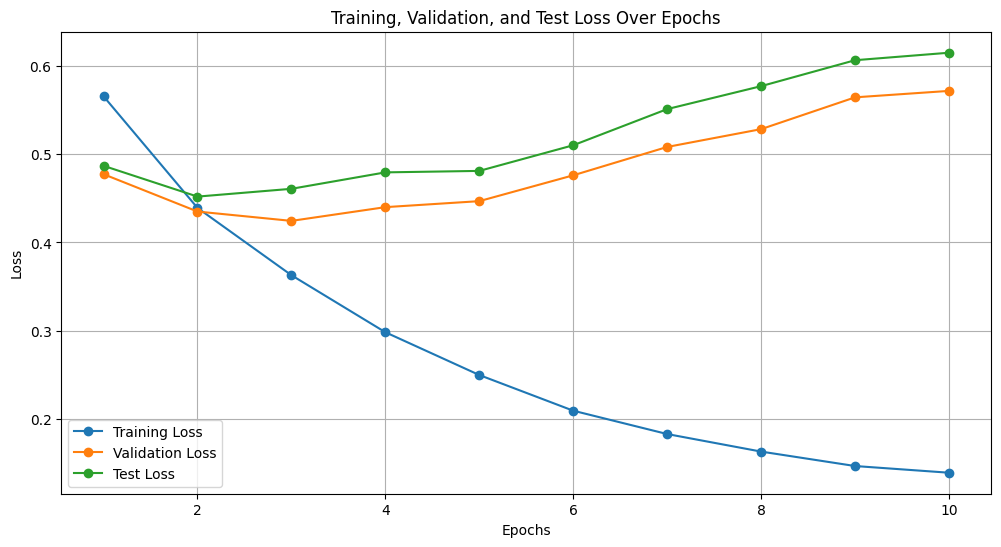

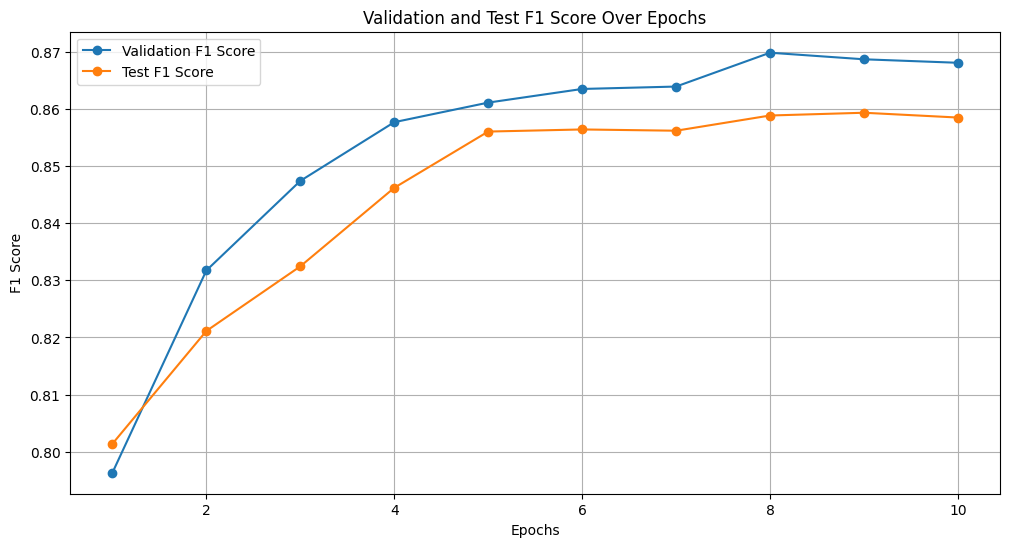

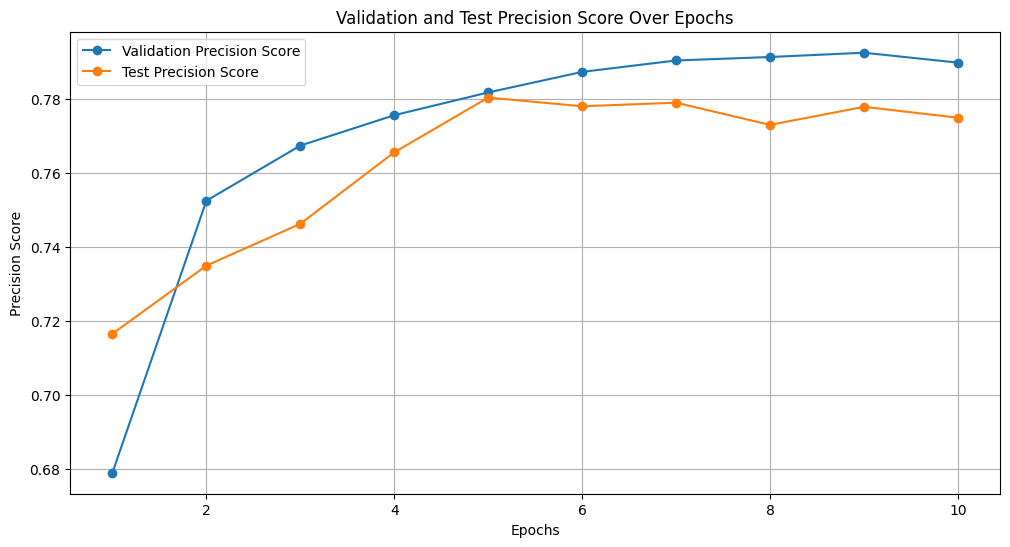

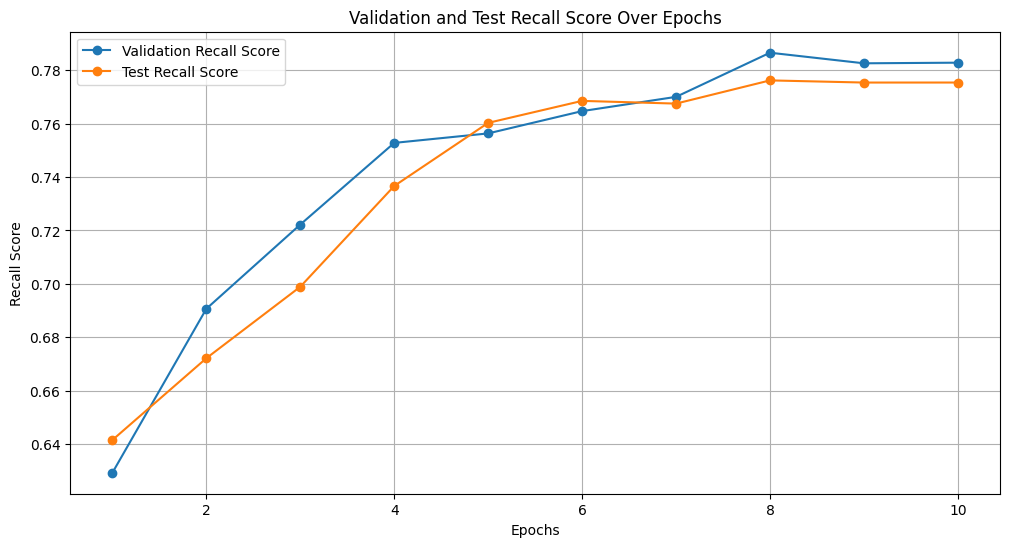

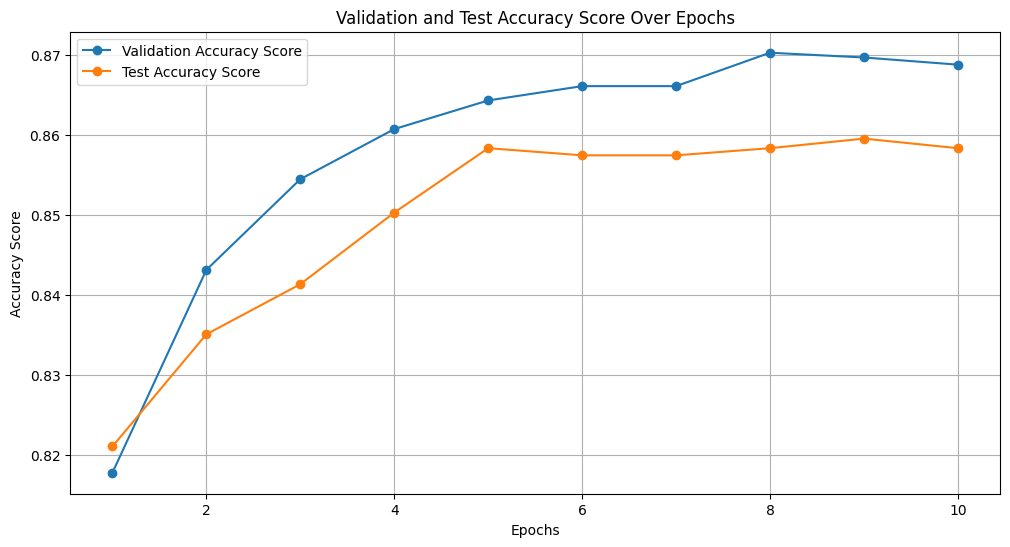

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Menggunakan range(1, len(train_losses) + 1) untuk sumbu x
epochs = range(1, len(train_losses) + 1)

# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.title('Training, Validation, and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1 Score
plt.figure(figsize=(12, 6))
plt.plot(epochs, f1_scores, label='Validation F1 Score', marker='o')
plt.plot(epochs, test_f1_scores, label='Test F1 Score', marker='o')
plt.title('Validation and Test F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision Score
plt.figure(figsize=(12, 6))
plt.plot(epochs, precision_scores, label='Validation Precision Score', marker='o')
plt.plot(epochs, test_precision_scores, label='Test Precision Score', marker='o')
plt.title('Validation and Test Precision Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Recall Score
plt.figure(figsize=(12, 6))
plt.plot(epochs, recall_scores, label='Validation Recall Score', marker='o')
plt.plot(epochs, test_recall_scores, label='Test Recall Score', marker='o')
plt.title('Validation and Test Recall Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy Score
plt.figure(figsize=(12, 6))
plt.plot(epochs, accuracy_scores, label='Validation Accuracy Score', marker='o')
plt.plot(epochs, test_accuracy_scores, label='Test Accuracy Score', marker='o')
plt.title('Validation and Test Accuracy Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()


In [39]:
# Menggunakan training_status yang sudah ada untuk hasil evaluasi
results = []
for epoch_result in training_status:
    epoch_metrics = {
        'Epoch': epoch_result['epoch'],
        'Training Loss': epoch_result['Training Loss'],
        'Validation Loss': epoch_result['Valid. Loss'],
        'F1 Score (Val)': epoch_result['F1 Score'],
        'Precision Score (Val)': epoch_result['Precision Score'],
        'Recall Score (Val)': epoch_result['Recall Score'],
        'Accuracy Score (Val)': epoch_result['Accuracy Score'],
        'Test Loss': epoch_result['Test Loss'],
        'Test F1 Score': epoch_result['Test F1 Score'],
        'Test Precision Score': epoch_result['Test Precision Score'],
        'Test Recall Score': epoch_result['Test Recall Score'],
        'Test Accuracy Score': epoch_result['Test Accuracy Score']
    }
    results.append(epoch_metrics)

# Buat DataFrame dari hasil evaluasi
df = pd.DataFrame(results)

# Tampilkan DataFrame
print(df)


   Epoch  Training Loss  Validation Loss  F1 Score (Val)  \
0      1       0.565724         0.477374        0.796343   
1      2       0.439135         0.435003        0.831719   
2      3       0.362795         0.424413        0.847386   
3      4       0.298097         0.439996        0.857655   
4      5       0.249562         0.446801        0.861080   
5      6       0.209090         0.476107        0.863467   
6      7       0.182619         0.508274        0.863887   
7      8       0.162714         0.528479        0.869805   
8      9       0.146337         0.564553        0.868657   
9     10       0.138745         0.571866        0.868046   

   Precision Score (Val)  Recall Score (Val)  Accuracy Score (Val)  Test Loss  \
0               0.679091            0.629242              0.817747   0.486878   
1               0.752461            0.690672              0.843143   0.451960   
2               0.767353            0.722230              0.854497   0.460798   
3              

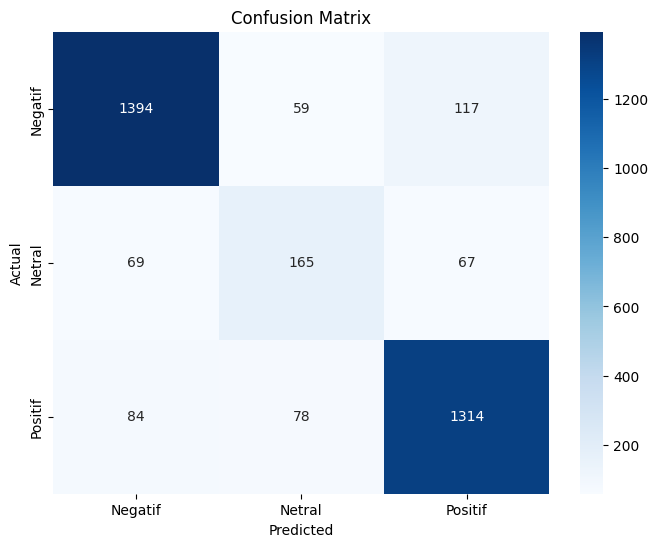

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluasi model pada data uji
test_loss, test_predictions, test_true_vals = evaluate_test(dataloader_test)

# Membuat confusion matrix
confusion = confusion_matrix(test_true_vals, test_predictions.argmax(axis=1))

# Daftar label kelas
class_labels = ["Negatif", "Netral", "Positif"]

# Membuat heatmap dari confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
